In [1]:
#cd
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [9]:
#imports
import torch
import torch.nn.functional as F
from torch.nn import Linear
from itertools import product
import time
from torch import tensor
from torch.optim import Adam
from torch.optim import SGD
from math import ceil
from torch.nn import Linear
from torch.distributions import categorical
from torch.distributions import Bernoulli
import torch.nn
%matplotlib inline
from matplotlib import pyplot as plt
from torch_geometric.utils import convert as cnv
from torch_geometric.utils import sparse as sp
from torch_geometric.data import Data
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from torch.utils.data.sampler import RandomSampler
from torch.nn.functional import gumbel_softmax
from torch.distributions import relaxed_categorical
import myfuncs
from torch_geometric.nn.inits import uniform
from torch_geometric.nn.inits import glorot, zeros
from torch.nn import Parameter
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree
from torch_geometric.nn import GINConv, GATConv, global_mean_pool, NNConv, GCNConv
from torch.nn import Parameter
from torch.nn import Sequential as Seq, Linear, ReLU, LeakyReLU
from torch_geometric.nn import MessagePassing
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.data import Batch 
from torch_scatter import scatter_min, scatter_max, scatter_add, scatter_mean
from torch import autograd
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.utils import softmax, add_self_loops, remove_self_loops, segregate_self_loops, remove_isolated_nodes, contains_isolated_nodes, add_remaining_self_loops
from torch_geometric.utils import dropout_adj, to_undirected, to_networkx
from torch_geometric.utils import is_undirected
from cut_utils import get_diracs
import scipy
import scipy.io
from matplotlib.lines import Line2D
from torch_geometric.utils.convert import from_scipy_sparse_matrix
import GPUtil
from networkx.algorithms.approximation import max_clique
import pickle
from torch_geometric.nn import SplineConv, global_mean_pool, DataParallel
from torch_geometric.data import DataListLoader, DataLoader
from random import shuffle
from networkx.algorithms.approximation import max_clique
from networkx.algorithms import graph_clique_number
from networkx.algorithms import find_cliques
from torch_geometric.nn.norm import graph_size_norm
from torch_geometric.datasets import TUDataset
import visdom 
from visdom import Visdom 
import numpy as np
import matplotlib.pyplot as plt
from models import clique_MPNN
from torch_geometric.nn.norm.graph_size_norm import GraphSizeNorm
from modules_and_utils import decode_clique_final, decode_clique_final_speed

In [10]:
K = 40 # no of users
with open("F:\\channel_40_1", "rb") as fp:
    dataset = pickle.load(fp)
    
dataset_scale = 1
total_samples = int(np.floor(len(dataset)*dataset_scale))
dataset = dataset[:total_samples]

num_trainpoints = int(np.floor(0.6*len(dataset)))
num_valpoints = int(np.floor(num_trainpoints/3))
num_testpoints = len(dataset) - (num_trainpoints + num_valpoints)

data_list = []
for i in range(1000):
    data_list.append(Data(x = dataset[i]["x"], num_nodes = K, edge_index = dataset[i]["edge_index"], edge_weight = dataset[i]["edge_weight"]))


traindata= data_list[0:num_trainpoints]
valdata = data_list[num_trainpoints:num_trainpoints + num_valpoints]
testdata = data_list[num_trainpoints + num_valpoints:]


batch_size = 1
train_loader = DataLoader(traindata, batch_size, shuffle=False)
for data in testdata:
    print(data)


#set up random seeds 
torch.manual_seed(1)
np.random.seed(2)   
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Data(x=[40, 1], edge_index=[2, 1046], num_nodes=40, edge_weight=[1046])
Data(x=[40, 1], edge_index=[2, 1084], num_nodes=40, edge_weight=[1084])
Data(x=[40, 1], edge_index=[2, 1020], num_nodes=40, edge_weight=[1020])
Data(x=[40, 1], edge_index=[2, 1050], num_nodes=40, edge_weight=[1050])
Data(x=[40, 1], edge_index=[2, 1044], num_nodes=40, edge_weight=[1044])
Data(x=[40, 1], edge_index=[2, 1042], num_nodes=40, edge_weight=[1042])
Data(x=[40, 1], edge_index=[2, 1050], num_nodes=40, edge_weight=[1050])
Data(x=[40, 1], edge_index=[2, 1068], num_nodes=40, edge_weight=[1068])
Data(x=[40, 1], edge_index=[2, 1044], num_nodes=40, edge_weight=[1044])
Data(x=[40, 1], edge_index=[2, 1082], num_nodes=40, edge_weight=[1082])
Data(x=[40, 1], edge_index=[2, 1066], num_nodes=40, edge_weight=[1066])
Data(x=[40, 1], edge_index=[2, 1026], num_nodes=40, edge_weight=[1026])
Data(x=[40, 1], edge_index=[2, 1024], num_nodes=40, edge_weight=[1024])
Data(x=[40, 1], edge_index=[2, 1042], num_nodes=40, edge_weight=

In [11]:
#number of propagation layers
numlayers = 8

#size of receptive field
receptive_field = numlayers + 1

# val_losses = []
# cliq_dists = []

net =  clique_MPNN(dataset,numlayers, 128, 128,1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
lr_decay_step_size = 5
lr_decay_factor = 0.95

net.to(device).reset_parameters()
optimizer = Adam(net.parameters(), lr=0.001, weight_decay=0.00)


In [12]:

b_sizes = [50]
l_rates = [0.001]
depths = [8]
coefficients = [4.]
rand_seeds = [66]
widths = [64]

epochs = 100
net.train()
retdict = {}
edge_drop_p = 0.0
edge_dropout_decay = 0.90



for batch_size, learning_rate, numlayers, penalty_coeff, r_seed, hidden_1 in product(b_sizes, l_rates, depths, coefficients, rand_seeds, widths):
   
    torch.manual_seed(r_seed)

    train_loader = DataLoader(traindata, batch_size, shuffle=True)
    test_loader = DataLoader(testdata, batch_size, shuffle=False)
    val_loader =  DataLoader(valdata, batch_size, shuffle=False)

    receptive_field= numlayers + 1
    val_losses = []
    cliq_dists = []

    hidden_2 = 1

    net =  clique_MPNN(dataset,numlayers, hidden_1, hidden_2 ,1)
    net.to(device).reset_parameters()
    optimizer = Adam(net.parameters(), lr=learning_rate, weight_decay=0.00000)

    for epoch in range(epochs):
        totalretdict = {}
        count=0
        if epoch % 5 == 0:
            edge_drop_p = edge_drop_p*edge_dropout_decay
            print("Edge_dropout: ", edge_drop_p)

        if epoch % 10 == 0:
            penalty_coeff = penalty_coeff + 0.
            print("Penalty_coefficient: ", penalty_coeff)

        print("here2")
        #learning rate schedule
        if epoch % lr_decay_step_size == 0:
            for param_group in optimizer.param_groups:
                        param_group['lr'] = lr_decay_factor * param_group['lr']

        #show currrent epoch and GPU utilizationss
        print('Epoch: ', epoch)
        GPUtil.showUtilization()



        #print("here3")


        net.train()
        for data in train_loader
            count += 1 
            optimizer.zero_grad(), 
            data = data.to(device)
            data_prime = get_diracs(data, 1, sparse = True, effective_volume_range=0.15, receptive_field = receptive_field)

            data = data.to('cpu')
            data_prime = data_prime.to(device)
#             print(data_prime)


#             retdict = net(data_prime, None, penalty_coeff)
            retdict = net(data_prime, data.edge_weight.to(device), None, penalty_coeff)

            for key,val in retdict.items():
                if "sequence" in val[1]:
                    if key in totalretdict:
                        totalretdict[key][0] += val[0].item()
                    else:
                        totalretdict[key] = [val[0].item(),val[1]]

            if epoch > 2:
                    retdict["loss"][0].backward()
                    #reporter.report()

                    torch.nn.utils.clip_grad_norm_(net.parameters(),1)
                    optimizer.step()
                    del(retdict)

        if epoch > -1:        
            for key,val in totalretdict.items():
                if "sequence" in val[1]:
                    val[0] = val[0]/(len(train_loader.dataset)/batch_size)
            del data_prime

Edge_dropout:  0.0
Penalty_coefficient:  4.0
here2
Epoch:  0
| ID | GPU | MEM |
------------------
|  0 |  0% | 22% |
here2
Epoch:  1
| ID | GPU | MEM |
------------------
|  0 | 29% | 30% |


KeyboardInterrupt: 

In [13]:
tbatch_size = batch_size
num_data_points = num_testpoints

batch_size = 1
test_data = testdata
test_loader = DataLoader(test_data, batch_size, shuffle=False)
net.to(device)
count = 1
bound = 4
#Evaluation on test set
net.eval()

gnn_nodes = []
gnn_edges = []
gnn_sets = {}

#set number of samples according to your execution time, for 10 samples
max_samples = 1

gnn_times = []
num_samples = max_samples
t_start = time.time()

for data in test_loader:
    num_graphs = data.batch.max().item()+1
    bestset = {}
    bestedges = np.zeros((num_graphs))
    maxset = np.zeros((num_graphs))
    print(data)
    total_samples = []
    for graph in range(num_graphs):
        curr_inds = (data.batch==graph)
        g_size = curr_inds.sum().item()
        if max_samples <= g_size: 
            samples = np.random.choice(curr_inds.sum().item(),max_samples, replace=False)
        else:
            samples = np.random.choice(curr_inds.sum().item(),max_samples, replace=True)

        total_samples +=[samples]

    data = data.to(device)
    t_0 = time.time()

    for k in range(num_samples):
        t_datanet_0 = time.time()
        data_prime = get_diracs(data.to(device), 1, sparse = True, effective_volume_range=0.15, receptive_field = 7)
  
        initial_values = data_prime.x.detach()
        data_prime.x = torch.zeros_like(data_prime.x)
        g_offset = 0
        for graph in range(num_graphs):
            curr_inds = (data_prime.batch==graph)
            g_size = curr_inds.sum().item()
            graph_x = data_prime.x[curr_inds]
            data_prime.x[total_samples[graph][k] + g_offset]=1.
            g_offset += g_size
            
        retdz = net(data_prime, data.edge_weight)
#         retdz = net(data_prime)
        
        t_datanet_1 = time.time() - t_datanet_0
#         print("data prep and fp: ", t_datanet_1)
        t_derand_0 = time.time()

        sets, set_edges, set_cardinality = decode_clique_final_speed(data_prime, data.edge_weight.to(device), (retdz["output"][0]), weight_factor =0., clique_number_bounds = bound, draw=False, beam = 1)

        t_derand_1 = time.time() - t_derand_0
#         print("Derandomization time: ", t_derand_1)

        for j in range(num_graphs):
            indices = (data.batch == j)
            if (set_cardinality[j]>maxset[j]):
                    maxset[j] = set_cardinality[j].item()
                    bestset[str(j)] = sets[indices].cpu()
                    bestedges[j] = set_edges[j].item()

    t_1 = time.time()-t_0
    print("Current batch: ", count)
#     print("Time so far: ", time.time()-t_0)
    gnn_sets[str(count)] = bestset
    
    gnn_nodes += [maxset]
    gnn_edges += [bestedges]
    gnn_times += [t_1]

    count += 1

t_1 = time.time()
total_time = t_1 - t_start
print("Average time per graph: ", total_time/(len(test_data)))

# print(maxset)
# print(bestset)
# print(gnn_sets)


DataBatch(x=[40, 1], edge_index=[2, 1046], num_nodes=40, edge_weight=[1046], batch=[40], ptr=[2])
Current batch:  1
DataBatch(x=[40, 1], edge_index=[2, 1084], num_nodes=40, edge_weight=[1084], batch=[40], ptr=[2])
Current batch:  2
DataBatch(x=[40, 1], edge_index=[2, 1020], num_nodes=40, edge_weight=[1020], batch=[40], ptr=[2])
Current batch:  3
DataBatch(x=[40, 1], edge_index=[2, 1050], num_nodes=40, edge_weight=[1050], batch=[40], ptr=[2])
Current batch:  4
DataBatch(x=[40, 1], edge_index=[2, 1044], num_nodes=40, edge_weight=[1044], batch=[40], ptr=[2])
Current batch:  5
DataBatch(x=[40, 1], edge_index=[2, 1042], num_nodes=40, edge_weight=[1042], batch=[40], ptr=[2])
Current batch:  6
DataBatch(x=[40, 1], edge_index=[2, 1050], num_nodes=40, edge_weight=[1050], batch=[40], ptr=[2])
Current batch:  7
DataBatch(x=[40, 1], edge_index=[2, 1068], num_nodes=40, edge_weight=[1068], batch=[40], ptr=[2])
Current batch:  8
DataBatch(x=[40, 1], edge_index=[2, 1044], num_nodes=40, edge_weight=[10

Current batch:  71
DataBatch(x=[40, 1], edge_index=[2, 1042], num_nodes=40, edge_weight=[1042], batch=[40], ptr=[2])
Current batch:  72
DataBatch(x=[40, 1], edge_index=[2, 1032], num_nodes=40, edge_weight=[1032], batch=[40], ptr=[2])
Current batch:  73
DataBatch(x=[40, 1], edge_index=[2, 1068], num_nodes=40, edge_weight=[1068], batch=[40], ptr=[2])
Current batch:  74
DataBatch(x=[40, 1], edge_index=[2, 1056], num_nodes=40, edge_weight=[1056], batch=[40], ptr=[2])
Current batch:  75
DataBatch(x=[40, 1], edge_index=[2, 1030], num_nodes=40, edge_weight=[1030], batch=[40], ptr=[2])
Current batch:  76
DataBatch(x=[40, 1], edge_index=[2, 1060], num_nodes=40, edge_weight=[1060], batch=[40], ptr=[2])
Current batch:  77
DataBatch(x=[40, 1], edge_index=[2, 1080], num_nodes=40, edge_weight=[1080], batch=[40], ptr=[2])
Current batch:  78
DataBatch(x=[40, 1], edge_index=[2, 1004], num_nodes=40, edge_weight=[1004], batch=[40], ptr=[2])
Current batch:  79
DataBatch(x=[40, 1], edge_index=[2, 1058], nu

Current batch:  141
DataBatch(x=[40, 1], edge_index=[2, 1052], num_nodes=40, edge_weight=[1052], batch=[40], ptr=[2])
Current batch:  142
DataBatch(x=[40, 1], edge_index=[2, 1072], num_nodes=40, edge_weight=[1072], batch=[40], ptr=[2])
Current batch:  143
DataBatch(x=[40, 1], edge_index=[2, 1048], num_nodes=40, edge_weight=[1048], batch=[40], ptr=[2])
Current batch:  144
DataBatch(x=[40, 1], edge_index=[2, 1034], num_nodes=40, edge_weight=[1034], batch=[40], ptr=[2])
Current batch:  145
DataBatch(x=[40, 1], edge_index=[2, 1040], num_nodes=40, edge_weight=[1040], batch=[40], ptr=[2])
Current batch:  146
DataBatch(x=[40, 1], edge_index=[2, 1094], num_nodes=40, edge_weight=[1094], batch=[40], ptr=[2])
Current batch:  147
DataBatch(x=[40, 1], edge_index=[2, 1076], num_nodes=40, edge_weight=[1076], batch=[40], ptr=[2])
Current batch:  148
DataBatch(x=[40, 1], edge_index=[2, 1006], num_nodes=40, edge_weight=[1006], batch=[40], ptr=[2])
Current batch:  149
DataBatch(x=[40, 1], edge_index=[2, 

801
802
803
804
805
806
807
808


C:\Users\ronal\anaconda3\envs\pygeo\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ronal\anaconda3\envs\pygeo\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
[[21 35  1  9]
 [25 18 16 21]
 [ 0 24 28 15]
 [25 31 19 38]
 [11 24 36 18]
 [29 33  9 12]
 [22 20  3 18]
 [25  0 36  1]
 [34 28 26  2]
 [15 19  5 35]
 [ 1 37  9  6]
 [ 0 12 23 24]
 [ 0 15 17 10]
 [25 23  4  9]
 [33 18 29 36]
 [ 3 25  6 

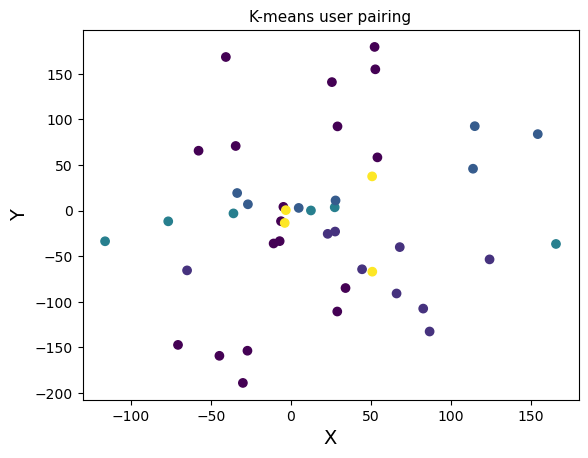

In [14]:
import numpy as np
import scipy.io as sio 
from matplotlib import pyplot as plt
from torch_scatter import scatter_min, scatter_max, scatter_add, scatter_mean
N = 100;
number = K;
k = bound
z = [[] for i in range(k)]
l = [[] for i in range(k)]
x = [[] for i in range(k)]
y = [[] for i in range(k)]
xm = []
ym = []
idx = []
def k_means(U, A, k, centers=None, num_iter=10):
    if centers is None:
        rnd_centers_idx = np.random.choice(np.arange(U.shape[0]), k, replace=False)
        centers = U[rnd_centers_idx]
        UUh = np.zeros([K,N,N], dtype = np.csingle)
        for i in range(K):
            r = np.count_nonzero(A[i,:,:] > 0.001)
            UUh[i,:,:] = U[i,:,N-r:N-1] @ U[i,:,N-r:N-1].conj().T
 
        VVh = np.zeros([k,N,N], dtype = np.csingle)
        for i in range(k):
            r = np.count_nonzero(A[rnd_centers_idx[i],:,:] > 0.001)
            VVh[i,:,:] = U[rnd_centers_idx[i],:,N-r:N-1] @ U[rnd_centers_idx[i],:,N-r:N-1].conj().T

    tot_dist_curr = 9999 
    tot_dist_prev = 0 
#     while np.abs(tot_dist_prev - tot_dist_curr)>1:
    for ur in range(5):
        tot_dist_prev = tot_dist_curr
        distances = (np.linalg.norm((UUh - VVh[:,np.newaxis]), axis=(2,3)))
        tot_dist_curr = np.sum(distances)
        cluster_assignments = np.argmin(distances, axis=0)
        for i in range(k):
            msk = (cluster_assignments == i)
            Z = UUh[cluster_assignments == i]
            Z = np.sum(Z, axis=0)/(np.count_nonzero(cluster_assignments == i)+1)
            LambdaW, W = np.linalg.eig((Z+Z.conj().T)/2)
            LambdaW = np.abs(LambdaW)
            idx = LambdaW.argsort()[::-1]   
            LambdaW = LambdaW[idx]
            W = W[:,idx]
            
            r = np.count_nonzero(LambdaW > 0.1)
            W = W[:,1:r]
            del LambdaW
            VVh[i,:,:] = W @ W.conj().T
    return cluster_assignments
to = 199
users_ind_kmeans = np.zeros([to,k])
users_ind_kmeans = users_ind_kmeans.astype('i')
k = bound
for iteration in range(801,801+to):
    print(iteration)

    mat = sio.loadmat(f'F:\\dataset_{number}\\U{iteration+1}.mat')
    eigen = mat['U'] 
    mat = sio.loadmat(f'F:\\dataset_{number}\\A{iteration+1}.mat')
    lamda = mat['A']
    labels = k_means(eigen,lamda,k)
    mat = sio.loadmat(f'F:\\dataset_{number}\\x{iteration+1}.mat')
    X = mat['x']
    mat = sio.loadmat(f'F:\\dataset_{number}\\y{iteration+1}.mat')
    Y = mat['y']
    z = [[] for i in range(k)]
    l = [[] for i in range(k)]
    x = [[] for i in range(k)]
    y = [[] for i in range(k)]
    for i in range(K):
        for j in range(k):
            if labels[i] == j:
                x[j].append(X[0,i])
                y[j].append(Y[0,i])
    xm = []
    for i in range(k):
        xm.append(np.mean(x[i]))
    ym = []
    for i in range(k):
        ym.append(np.mean(y[i]))
    for i in range(K):
        for j in range(k):
            if labels[i] == j:
                z[j].append(((X[0,i]-xm[j])**2+(Y[0,i]-ym[j])**2))
                l[j].append(i)
    for j in range(k):
        if np.size(z[j])%2==0:
            z[j].append(999999)

    idx = []
    for j in range(k):
        idx.append(np.argsort(z[j])[0])
    for j in range(k):
        if not l[j]:
            l[j].append(0)
        users_ind_kmeans[iteration-801][j] = l[j][idx[j]]

print(users_ind_kmeans)
   
labels = np.append(labels,[7, 7, 7, 7])
# labels = np.append(labels,[7, 7, 7, 7, 7, 7])
# x = np.append(X,[xm[0], xm[1], xm[2], xm[3], xm[4], xm[5]])
# y = np.append(Y,[ym[0], ym[1], ym[2], ym[3], ym[4], ym[5]])
x = np.append(X,[xm[0], xm[1], xm[2], xm[3]])
y = np.append(Y,[ym[0], ym[1], ym[2], ym[3]])
print(np.size(labels))

plt.scatter(x,y, c=labels)
plt.title('K-means user pairing', fontsize=11)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
# plt.scatter([xm1 xm2 xm3],[ym1 ym2 ym3], c=[5 5 5])
plt.show()

40


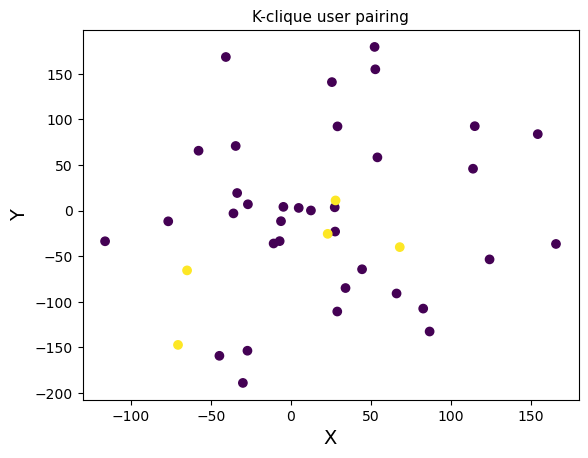

In [15]:
# print(np.shape(users_ind_kmeans))
print(K)
users = gnn_sets[str(to)]['0']
# print((users))
mat = sio.loadmat(f'F:\\dataset_{number}\\x{801+to}.mat')
X = mat['x']
mat = sio.loadmat(f'F:\\dataset_{number}\\y{801+to}.mat')
Y = mat['y']

plt.scatter(X,Y,c=users)
plt.title('K-clique user pairing', fontsize=11)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

In [16]:
alpha = 0.01
users_ind_sus = np.zeros([to,k])
users_ind_sus = users_ind_sus.astype('i')
for p in range(801,801+to):
    T = list(range(0,K))
    P = [] 
    i = 0
    mat = sio.loadmat(f'F:\\dataset_{number}\\H{p}.mat')
    H = mat['H']
    g = H
    cond = np.size(P) < k+1
    while T and cond:
        i += 1
        
        for q in range(0,np.size(T)):
            gs = 0
            for j in range(0,i-1):
                gs += ((H[:,T[q]].T @ g[:,P[j]].conj())/np.linalg.norm(g[:,P[j]])**2) * g[:,P[j]]
            g[:,T[q]] = H[:,T[q]] - gs
        G = np.linalg.norm(g[:,T], axis = 0)
        P.append(T[np.argmax(G)])
        val = T[np.argmax(G)]
        T.remove(T[np.argmax(G)])
        Q = []
        for r in range(0,np.size(T)):
            sus = (H[:,T[r]].T @ g[:,val].conj())/(np.linalg.norm(H[:,T[r]])*np.linalg.norm(g[:,val]))
            if sus < alpha:
                Q.append(T[r])
        
        for s in range(0,np.size(Q)):
            T.remove(Q[s])
        cond = np.size(P) < k+1
        if np.size(P) == k or not T and cond:
            for idx in range(0,np.size(P)):
                users_ind_sus[p-801][idx] = P[idx]
        
print(users_ind_sus)


[[11  9 20  0]
 [12 36 14  0]
 [34 37  4  0]
 [36 18 19 21]
 [28  3 21  0]
 [29  6 32 28]
 [10 36 38 27]
 [17  0 33 38]
 [11 18 23  0]
 [23 10 28 30]
 [15 24  4  8]
 [23 13 20 27]
 [38  6 29 35]
 [ 5 38 32  0]
 [ 1 24  8  0]
 [10 11 22  0]
 [14 18  0  0]
 [29 33 21  5]
 [39  0 18 20]
 [24 17 27  3]
 [16 14 24  0]
 [ 9 28  6 33]
 [ 2 22  0  0]
 [ 2  3  4 27]
 [ 5  3 25  0]
 [25 24  0  0]
 [25 38 17 36]
 [25 21  4 39]
 [12 26 34  0]
 [ 4  1 13  0]
 [36 18 28 14]
 [38 32  0  0]
 [26 25 11 28]
 [38  0 24  8]
 [20 16 11  0]
 [28 35 12 18]
 [23 32 26 21]
 [14 20 32 31]
 [16 37  7  0]
 [ 0 10 14 13]
 [32 39 27 26]
 [ 1 10  0  0]
 [ 4  1 13  0]
 [27 39 26 35]
 [19  6 26 17]
 [25 12  0  0]
 [11 31 14 37]
 [31 36  9 29]
 [37  8  0  0]
 [ 7 31 35  0]
 [13  0 19  0]
 [ 5 15  4 11]
 [21 25 15  5]
 [ 5 17  2 28]
 [39 21  0  0]
 [ 6 22  8  2]
 [ 4 36  8  0]
 [14  4 30  0]
 [34 30  0  0]
 [10  8 22  0]
 [ 5 33 14 26]
 [27 35  0  0]
 [ 7 26  6  0]
 [12 38  4  0]
 [10 23 22 35]
 [ 9 30 18  0]
 [20 31 33

In [17]:
import numpy as np
from scipy.linalg import svd

def waterfilling(H,P):
    U, g, VT = svd(H)
#     print(np.shape(VT))
    alpha_low = 0 # Initial low
    alpha_high = (P + np.sum(1/g**2)) # Initial high

    stop_threshold = 1e-7 # Stop threshold

    # Iterate while low/high bounds are further than stop_threshold
    while(np.abs(alpha_low - alpha_high) > stop_threshold):
        alpha = (alpha_low + alpha_high) / 2 # Test value in the middle of low/high

        # Solve the power allocation
        p = 1/alpha - 1/g**2 
        p[p < 0] = 0 # Consider only positive power allocation

        # Test sum-power constraints
        if (np.sum(p) > P): # Exceeds power limit => lower the upper bound
            alpha_low = alpha
        else: # Less than power limit => increase the lower bound
            alpha_high = alpha
    return p


0
5
10
15
20
25
30


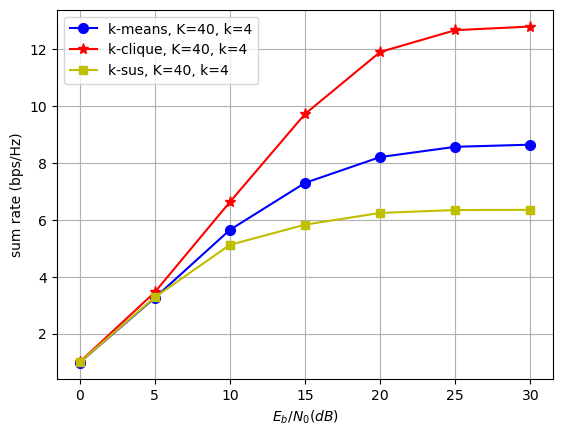

In [20]:
import scipy.io as sio 
import matplotlib.pyplot as plt

def sumrate(ebn,num):
    snr = 10**(ebn/10)
    sr_kmeans = []
    sr_clique = []
    sr_sus    = []
    dpc_kmeans= []
    dpc_clique= []
    
    users = gnn_sets[str(num-800)]['0']
    users_ind_clique = torch.argwhere(users)
    power_clique = 0
    power_dpc_clique = 0
    power_dpc_kmeans = 0
    interference_clique = 0
    capacity_clique = 0
    power_kmeans = 0
    interference_kmeans = 0
    capacity_kmeans = 0
    power_dbscan = 0
    interference_dbscan = 0
    capacity_dbscan = 0
    power_sus = 0
    interference_sus = 0
    capacity_sus = 0
    mat = sio.loadmat(f'F:\\dataset_{number}\\H{num}.mat')
    H = mat['H']
    H = H/np.linalg.norm(H, axis = 0)
    p_clique = waterfilling(H[:,np.asarray(users_ind_clique).squeeze(-1)],snr)
    count=-1
    for k in users_ind_clique:
        count+=1
        idx = -1
        power_dpc_clique += p_clique[count]*(np.reshape(H[:,k],(N,1)) @ np.reshape(H[:,k],(N,1)).conj().T)
        for j in users_ind_clique:
            idx+=1
            power_clique += p_clique[idx]*snr*np.abs(H[:,k] @ H[:,j].conj().T)**2     
            
        interference_clique = power_clique - p_clique[count]*snr*np.abs(H[:,k] @ H[:,k].conj().T)**2      
        capacity_clique += np.log2((1 + power_clique)/(1 + interference_clique))
        
    sr_clique.append(capacity_clique)
    
    p_kmeans = waterfilling(H[:,users_ind_kmeans[num-801]],snr)
    count=-1
    for k in users_ind_kmeans[num-801]:
        count+=1
        idx = -1
        power_dpc_kmeans += p_kmeans[count]*(np.reshape(H[:,k],(N,1)) @ np.reshape(H[:,k],(N,1)).conj().T)
        for j in users_ind_kmeans[num-801]:
            idx+=1
            power_kmeans += p_kmeans[idx]*snr*np.abs(H[:,k] @ H[:,j].conj().T)**2
        interference_kmeans = power_kmeans - p_kmeans[count]*snr*np.abs(H[:,k] @ H[:,k].conj().T)**2        
        capacity_kmeans += np.log2((1 + power_kmeans)/(1 + interference_kmeans))
        
    sr_kmeans.append(capacity_kmeans)

    
    p_sus = waterfilling(H[:,users_ind_sus[num-801]],snr)
    count=-1
    for k in users_ind_sus[num-801]:
        count+=1
        idx = -1
        for j in users_ind_sus[num-801]:
            idx+=1
            power_sus += p_sus[idx]*snr*np.abs(H[:,k] @ H[:,j].conj().T)**2
        interference_sus = power_sus - p_sus[count]*snr*np.abs(H[:,k] @ H[:,k].conj().T)**2        
        capacity_sus += np.log2((1 + power_sus)/(1 + interference_sus))
        
    sr_sus.append(capacity_sus)
    
    return np.asarray(sr_clique), np.asarray(sr_kmeans), np.asarray(sr_sus)

    
number = K

ebn = list(range(0,31,5))
snr = [10**(x/10) for x in ebn]
sr_kmeans = [[] for i in range(to)]
sr_clique = [[] for i in range(to)]
sr_sus    = [[] for i in range(to)]
dpc_clique = [[] for i in range(to)]
dpc_kmeans = [[] for i in range(to)]
for i in ebn:
    print(i)
    for j in range(801,801+to):
        sr1, sr2, sr3 = sumrate(i,j)      
        sr_clique[j-801].append(sr1)
        sr_kmeans[j-801].append(sr2)
        sr_sus[j-801].append(sr3)

plt.plot(ebn,np.mean(sr_kmeans, axis=0), label='k-means, K=40, k=4', marker = 'o', ms = 7, c = 'b')
plt.plot(ebn,np.mean(sr_clique, axis=0), label='k-clique, K=40, k=4', marker = '*', ms = 8, c = 'r')
plt.plot(ebn,np.mean(sr_sus, axis=0), label='k-sus, K=40, k=4', marker = 's', ms = 6, c = 'y')
plt.xlabel(r'$E_{b}/N_{0} (dB)$')
plt.ylabel("sum rate (bps/Hz)")
plt.legend()
plt.grid(True)
plt.show()


# print(sr_clique)
# print(dpc)

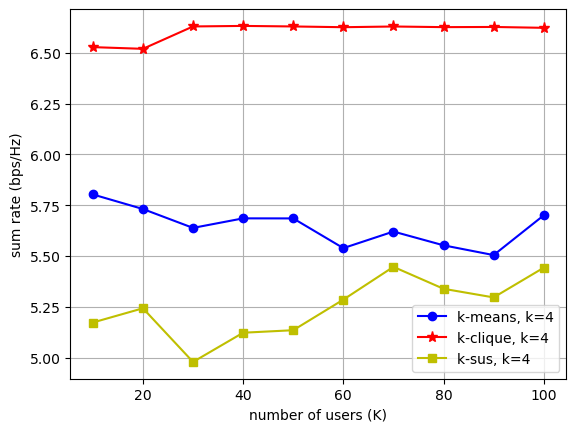

In [242]:
clique = [6.52799823, 6.51964084, 6.62973278, 6.63232852, 6.62970638, 6.62598411, 6.62950228, 6.62635731, 6.62720659, 6.62298049]
kmeans = [5.80317788, 5.73147345, 5.63851779, 5.68550135, 5.68521737, 5.53902121, 5.62057428, 5.55284441, 5.50474545, 5.7004235 ]
dpc    = [7.1993973 , 7.19962125, 7.22801259, 7.17494089, 7.22361739, 7.21458155, 7.22799199, 7.18094093, 7.20266438, 7.18952159]
sus    = [5.17295826, 5.24305174, 4.97910948, 5.12277046, 5.13511962, 5.28560087, 5.44692029, 5.33897954, 5.29645529, 5.44272452]
users = list(range(10, 101, 10))
plt.plot(users,kmeans, label='k-means, k=4', marker = 'o', ms = 6, c = 'b')
plt.plot(users,clique, label='k-clique, k=4', marker = '*', ms = 8, c = 'r')
plt.plot(users,sus, label='k-sus, k=4', marker = 's', ms = 6, c = 'y')
plt.xlabel('number of users (K)')
plt.ylabel("sum rate (bps/Hz)")
plt.legend()
plt.grid(True)
plt.show()

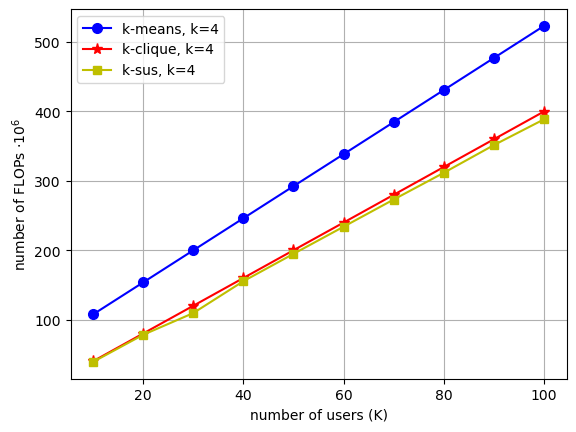

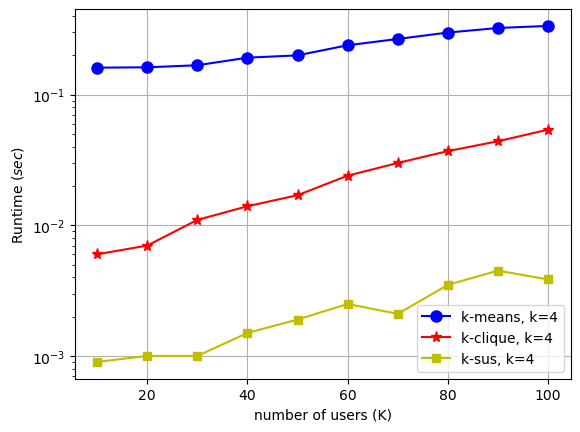

In [243]:
flops_clique = [39.98, 79.96, 119.9, 159.9, 199.9, 239.8, 279.8, 319.8, 359.8, 399.8]
flops_kmeans = [107.5, 153.6, 199.8, 246.0, 292.2, 338.3, 384.5, 430.7, 476.9, 523.1]
# flops_sus    = [46.99, 88.60, 130.9, 178.8, 235.8, 282.4, 332.2, 384.4, 430.7, 470.7]
flops_sus    = [39.04, 78.12, 109.4, 155.3, 194.7, 233.8, 273.0, 311.5, 351.4, 388.5]

lat_clique = [0.006, 0.007, 0.011, 0.014, 0.017, 0.024, 0.03, 0.037, 0.044, 0.054]
lat_kmeans = [0.161, 0.162, 0.168, 0.192, 0.2, 0.239, 0.267, 0.299, 0.324, 0.336]
lat_sus    = [0.0009, 0.0010, 0.0010, 0.0015, 0.0019, 0.0025, 0.0021, 0.0035, 0.0045, 0.00385]

plt.plot(users,flops_kmeans, label='k-means, k=4', marker = 'o', ms = 7, c = 'b')
plt.plot(users,flops_clique, label='k-clique, k=4', marker = '*', ms = 8, c = 'r')
plt.plot(users,flops_sus, label='k-sus, k=4', marker = 's', ms = 6, c = 'y')
plt.xlabel('number of users (K)')
plt.ylabel("number of FLOPs $ \cdot 10^{6}$")
plt.legend()
plt.grid(True)
plt.show()


plt.semilogy(users,lat_kmeans, label='k-means, k=4', marker = 'o', ms = 8, c = 'b')
plt.semilogy(users,lat_clique, label='k-clique, k=4', marker = '*', ms = 8, c = 'r')
plt.semilogy(users,lat_sus, label='k-sus, k=4', marker = 's', ms = 6, c = 'y')
plt.xlabel('number of users (K)')
plt.ylabel("Runtime $(sec)$")
plt.legend()
plt.grid(True)
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


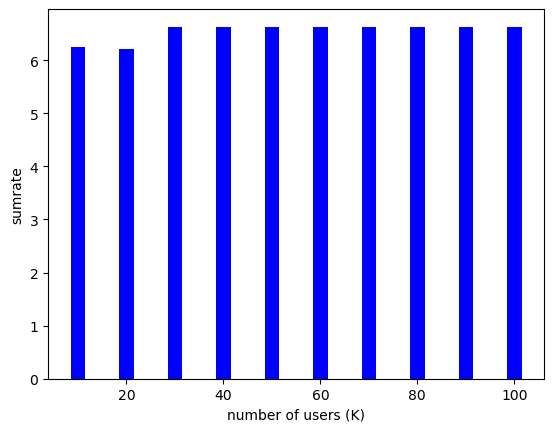

In [14]:
sr = [6.25853899, 6.19661747, 5.52504612, 5.72445559, 5.78752572, 5.63617305, 5.77002804, 5.80513293, 5.77119982, 5.75396522]
sm = [6.25082681, 6.20439943, 6.63113   , 6.63203779, 6.62999324, 6.62615638, 6.62810202, 6.62924805, 6.62601823, 6.62692901]
users = list(range(10, 101, 10))
print(users)
plt.bar(users,sm, color ='b', width = 3)
# plt.plot(ebn,np.mean(dpc_kmeans, axis=0), label='dpc_kmeans')
plt.xlabel('number of users (K)')
plt.ylabel("sumrate")
# plt.legend()
# plt.grid(True)
plt.show()